In [61]:
import jax
import jax.numpy as np
import numpy as onp
from jax import jit, grad

import numpy.random as rand
import seaborn as sns
import pandas as pd
from scipy.linalg import solve_discrete_are as dare
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [24]:
# Quadratic Loss
def quad_loss(x, u, Q = None, R = None):
    x_contrib = x.T @ x if Q is None else x.T @ Q @ x
    u_contrib = u.T @ u if R is None else u.T @ R @ u
    
    return np.sum(x_contrib + u_contrib)

In [25]:
class LQR:
    def __init__(self, T, A, B, Q = None, R = None):
        """
        Description: Initialize the infinite-time horizon LQR.
        Args:
            A, B (float/numpy.ndarray): system dynamics
            Q, R (float/numpy.ndarray): cost matrices (i.e. cost = x^TQx + u^TRu)
        """

        n, m = B[0].shape

        self.K = jnp.zeros((T, m, n))

        for t in range(T):
            if(t % 10 == 0):
                # Get system at current time
                At, Bt = A[t], B[t]
                Qt = np.eye(n, dtype=np.float32) if Q is None else Q[t]
                Rt = np.eye(m, dtype=np.float32) if R is None else R[t]

                # solve the ricatti equation 
                Xt = dare(At, Bt, Qt, Rt)

                #compute LQR gain
                Kt = np.linalg.inv(Bt.T @ Xt @ Bt + Rt) @ (Bt.T @ Xt @ At)
            self.K = jax.ops.index_update(self.K, t, Kt)

        self.t = 0

    def get_action(self, x):
        """
        Description: Return the action based on current state and internal parameters.

        Args:
            x (float/numpy.ndarray): current state

        Returns:
            u(float/numpy.ndarray): action to take
        """

        return -self.K[self.t] @ x

    def update(self, x):
        self.t += 1
    
    def __str__(self):
        return 'LQR'

In [89]:
class GPC:
    def __init__(self, T, A, B, Q = None, R = None, K=None, start_time = 0, cost_fn = quad_loss, \
        H = 3, HH = 2, lr_scale = 0.0001, lr_scale_decay = 1.0, decay = False, include_bias = True):
        """
        Description: Initialize the dynamics of the model
        Args:
            A,B (float/numpy.ndarray): system dynamics
            H (postive int): history of the controller 
            HH (positive int): history of the system 
            K (float/numpy.ndarray): Starting policy (optional). Defaults to LQR gain.
            x (float/numpy.ndarray): initial state (optional)
        """
        n, m = B[0].shape # State & Action Dimensions

        self.A, self.B = A, B # System Dynamics

        self.T = T - start_time
        self.t = 0 # Time Counter (for decaying learning rate)
        
        self.H, self.HH = H, HH
        self.lr_scale, self.lr_scale_decay = lr_scale, lr_scale_decay
        self.decay = decay
        self.include_bias = include_bias

        # Model Parameters 
        # initial linear policy / perturbation contributions / bias
        self.K = LQR(self.T, self.A, self.B, Q, R).K if K is None else K
        self.M, self.bias = np.zeros((H, m, n)), np.zeros((m, 1))

        # Past H + HH noises
        self.w = np.zeros((H + HH, n, 1))

        # past state and past action
        self.x, self.u = np.zeros((n, 1)), np.zeros((m, 1)) 
        
        # The Surrogate Cost Function
        def policy_loss(M, bias, w, t):
            y = np.zeros((n, 1))
            t0 = t - HH + 1
            for h in range(HH - 1):
                v = -self.K[t0 + h] @ y 
                v += np.tensordot(M, w[h : h + H], axes = ([0, 2], [0, 1])) 
                v += bias
                y = self.A[t0 + h] @ y + self.B[t0 + h] @ v + w[h + H]
            # Don't update state at the end    
            v = -self.K[t] @ y + np.tensordot(M, w[h : h + H], axes = ([0, 2], [0, 1])) + bias
            return cost_fn(y, v)
        
        self.policy_loss = policy_loss
        self.grad = jit(grad(policy_loss, (0, 1)))

    def update_params(self, x):

        if(self.t < self.HH - 1):
            return

        # 1. Get gradients
        delta_M, delta_bias = self.grad(self.M, self.bias, self.w, self.t)

        # 2. Execute updates
        lr = self.lr_scale_decay/(1+ self.t) if self.decay is True else self.lr_scale
        self.M -= lr * delta_M
        self.bias -= lr * delta_bias
        
    def update_noise(self, x):
        # 1. Get new noise (will be located at w[-1])
        self.w = jax.ops.index_update(self.w, 0, x - self.A[self.t] @ self.x - self.B[self.t] @ self.u)
        self.w = np.roll(self.w, -1, axis = 0)
#         val = x - self.A[self.t] @ self.x - self.B[self.t] @ self.u
#         self.w = np.vstack((self.w, val[None, :]))[1:]
        
    def update_history(self, x, u = None):
        # 2. Update x
        self.x = x
        
        # 3. Update u
        self.u = -self.K[self.t] @ x + np.tensordot(self.M, self.w[-self.H:], axes = ([0, 2], [0, 1])) \
                + self.bias * self.include_bias if u is None else u
        
    def update(self, x, u = None):
        self.update_params(x)
        self.update_noise(x)
        self.update_history(x, u)

        # 4. Update t
        self.t = self.t + 1

    def get_action(self, x):
        
        u = -self.K[self.t] @ x + np.tensordot(self.M, self.w[-self.H:], \
            axes = ([0, 2], [0, 1])) + self.bias * self.include_bias

        return u
    
    def __str__(self):
        return 'GPC'

In [64]:
onp.roll([1, 2, 3], -1)

array([2, 3, 1])

In [103]:
def lifetime(x):
  l = 8
  while x % 2 == 0:
    l *= 2
    x /= 2

  return min(T//8, l + 1)

In [104]:
tod = onp.arange(T)
for i in range(T):
  tod[i] = i + lifetime(i+1)
tod[0] = T//5

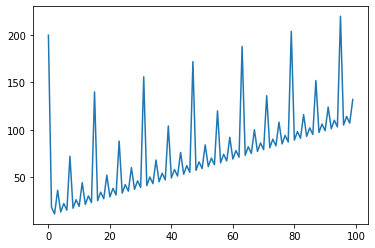

In [108]:
plt.plot(tod[:100])

In [28]:
class adaGPC:
    def __init__(self, T, model, hyperparams, eta = 1.00, eps = 0.00001, sum_weight = 1.0):

        # Start From Uniform Distribution
        self.T = T
        self.weights = onp.ones(self.T)
        self.probs = self.weights / self.T

        # Track current timestep
        self.t = 0 

        # Store Model Hyperparameters
        self.eta, self.eps, self.sum_weight = eta, eps, sum_weight

        self.u = np.zeros((hyperparams['B'][0].shape[1], 1))
        
        self.alive = set([0]) # Keep track of alive experts

        # Precompute time of death at initialization
        self.tod = onp.arange(T)
        for i in range(T):
          self.tod[i] = i + lifetime(i+1)
        self.tod[0] = T//5

        # Maintain Dictionary of Active Learners
        self.learners = {}
        self.learners[0] = model(**hyperparams)

        # Maintain a Dummy Controller
        self.dummy = model(**hyperparams)

        self.A, self.B = hyperparams['A'], hyperparams['B']
        self.K = LQR(T, hyperparams['A'], hyperparams['B'], hyperparams['Q'], hyperparams['R']).K

        # Store Baseline Controller Architecture for future use 
        self.model = model
        self.hyperparams = hyperparams
        
    def get_action(self, x):
      u = np.zeros((self.hyperparams['B'][0].shape[1], 1))
      W = 0
      for i in self.alive:
        #print("GPC no.", i, "ACTION:", self.learners[i].get_action(x), "chosen with weight", self.weights[i])
        u += self.weights[i] * self.learners[i].get_action(x)
        W += self.weights[i]
      Wtotal = W + self.sum_weight * (onp.sum(self.weights) - W)
      #print(W/Wtotal, "%GPC")
      #print("DUMMY ACTION:", (-self.K[self.t] @ x))
      self.u = (1. / Wtotal) * u + (Wtotal - W) / Wtotal * (-self.K[self.t] @ x)
      #print("CHOSEN ACTION:", self.u)
      return self.u 
    
    def update(self, x):

      loss_zero = self.dummy.policy_loss(self.dummy.M, self.dummy.bias, self.dummy.w, self.t)

      # Update weights and (old enough) models
      for i in range(min(self.t+1, self.T-21)):
        # If not yet dead, update with its weight
        if(self.tod[i] > self.t and (i+1)%16==0):
          try:
              loss_i = self.learners[i].policy_loss(self.learners[i].M, self.learners[i].bias, self.learners[i].w, self.t)
              self.weights[i] *= onp.exp(-self.eta * loss_i)
              self.weights[i] = max(self.weights[i], self.eps)
              self.weights[i] = min(self.weights[i], inf)
          except:
              self.weights[i] = self.eps 

          self.learners[i].update(x, self.u)

        # If already dead, just update with dummy loss
        else: 
          try:
              loss_i = loss_zero
              self.weights[i] *= onp.exp(-self.eta * loss_i)
              self.weights[i] = max(self.weights[i], self.eps)
              self.weights[i] = min(self.weights[i], inf)
          except:
              self.weights[i] = self.eps
  
      # For those not yet born, update with dummy loss
      for i in range(self.t+1, self.T):
          try:
              loss_i = loss_zero
              self.weights[i] *= onp.exp(-self.eta * loss_i)
              self.weights[i] = max(self.weights[i], self.eps)
              self.weights[i] = min(self.weights[i], inf)
          except:
              self.weights[i] = self.eps 

      self.dummy.update_noise(x) 
      self.dummy.update_history(x, self.u)
      
      self.t += 1

      # One is born
      if(self.t < self.T-20 and (self.t+1)%16==0):
        self.alive.add(self.t)
        hyperparams = self.hyperparams.copy()
        hyperparams['A'] = self.A[self.t:]
        hyperparams['B'] = self.B[self.t:]
        hyperparams['start_time'] = self.t
        hyperparams['K'] = self.K[self.t:]
        self.learners[self.t] = self.model(**hyperparams)
        self.learners[self.t].x, self.learners[self.t].u, self.learners[self.t].w = self.dummy.x, self.dummy.u, self.dummy.w

      # At most one dies
      kill_list = np.where(self.tod == self.t)
      if len(kill_list[0]):
        kill = int(kill_list[0][0])
        if(kill in self.alive):
          self.alive.remove(kill)
          del self.learners[kill]
          lost_weight = self.weights[kill]
          self.weights[kill] = self.eps
      
      if(onp.max(self.weights)<1):
        self.weights /= onp.max(self.weights)

        
    def __str__(self):
        return 'adaGPC'

In [97]:
def evaluate(T, A, B, Wgen, x0, controller, cost_fn):
    x, loss = x0, onp.zeros(T)
    n = x0.shape[0]
    for t in tqdm(range(T)):
        u = controller.get_action(x)
        controller.update(x)
        loss[t] = cost_fn(x, u)
        x = A[t] @ x + B[t] @ u + Wgen(n, t)
    return onp.array(loss, dtype=np.float32)

In [96]:
def evaluate(T, A, B, Wgen, x0, controller, cost_fn):
    n = x0.shape[0]
    def func(carry, val):
        a, b, t = val
        u = controller.get_action(carry)
        controller.update(carry)
        l = cost_fn(carry, u)
        carry = a @ carry + b @ u + Wgen(n, t)
        return carry, l
    x, loss = jax.lax.scan(func, x0, (A, B, jnp.arange(T)))
#     for t in tqdm(range(T)):
#         u = controller.get_action(x)
#         controller.update(x)
#         loss[t] = cost_fn(x, u)
#         x = A[t] @ x + B[t] @ u + Wgen(n, t)
    return onp.array(loss, dtype=np.float32)

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [30]:
alg_name = ['LQR', 'GPC', 'adaGPC']
color_code = {'LQR': 'blue', 'GPC': 'red', 'adaGPC': 'purple'}

In [31]:
cummean = lambda x: onp.cumsum(x)/(np.ones(T) + onp.arange(T))

def cummean(x):
  ans = onp.zeros(T)
  for i in range(1,T//5):
    ans[i] = onp.mean(x[:i])
  for i in range(T//5,T):
    ans[i] = onp.mean(x[i-T//5:i])
  return ans

def to_dataframe(alg, loss, avg_loss):
    global T
    return pd.DataFrame(data = {'Algorithm': alg, 'Time': onp.arange(T, dtype=np.float32),
                                'Instantaneous Cost': loss, 'Average Cost': avg_loss})

def get_results(T, A, B, Wgen, x0, model_class, model_params, rep = 3, cost_fn = quad_loss):
    all_data = []
    for r in range(rep):
        model = model_class(**model_params)
        loss = evaluate(T, A, B, Wgen, x0, model, cost_fn)
        avg_loss = list(cummean(loss))
        data = to_dataframe(str(model), list(loss), avg_loss)
        all_data.append(data)
                         
    all_data = pd.concat(all_data)
    return all_data

In [32]:
def plot_avg(title, data, scale = 'linear'):
    sns.lineplot(x = 'Time', y = 'Average Cost', hue = 'Algorithm', 
                 data = data, ci = 'sd', palette = color_code).set_title(title)

In [33]:
def plot_inst(title, data, scale = 'linear'):
    sns.lineplot(x = 'Time', y = 'Instantaneous Cost', hue = 'Algorithm', 
                 data = data, ci = 'sd', palette = color_code).set_title(title)

In [34]:
def experiment(exp_name, T, A, B, Wgen, Q = None, R = None, eta = 1.0, eps = 0.00001, lr_scale = 0.00001, \
               lr_scale_decay = 0.01, H = 3, HH = 3, decay = 0, include_bias = False, sum_weight = 1.0):
  if(decay == 0):
    gpc_decay, ada_gpc_decay = False, False
  elif(decay == 1):
    gpc_decay, ada_gpc_decay = False, True
  else:
    gpc_decay, ada_gpc_decay = True, True

  gpc_hyperparams = {'T': T, 'start_time' : 0, 'A' : A, 'B': B, 'Q': Q, 'R': R, 'lr_scale' : lr_scale, 'lr_scale_decay' : lr_scale_decay, 'H' : H, 'HH' : HH, 'decay' : gpc_decay, 'include_bias' : include_bias}
  ada_gpc_hyperparams = {'T': T, 'start_time' : 0, 'A' : A, 'B': B, 'Q': Q, 'R': R, 'lr_scale' : lr_scale, 'lr_scale_decay' : lr_scale_decay, 'H' : H, 'HH' : HH, 'decay' : ada_gpc_decay, 'include_bias' : include_bias}

  results_pd = []
  results_pd.append(get_results(T, A, B, Wgen, x0, LQR, {'T': T, 'A' : A, 'B': B, 'Q': Q, 'R': R}))
  results_pd.append(get_results(T, A, B, Wgen, x0, GPC, gpc_hyperparams))
  results_pd.append(get_results(T, A, B, Wgen, x0, adaGPC, {'T' : T, 'model' : GPC, 'hyperparams' : ada_gpc_hyperparams, \
                                    'eta':eta, 'eps':eps, 'sum_weight':sum_weight}))
  results_pd = pd.concat(results_pd)

  print("lr: ", lr_scale, "lr_decay", lr_scale_decay, "eta: ", eta, "decay:", decay, "sum_weight:", sum_weight)

  plot_avg(exp_name, results_pd)
  plt.savefig(exp_name + "_T=" + str(T) + "_decay=" + str(decay) + "_eta=" + str(eta) + "_lrs=" + str(lr_scale) + "," + str(lr_scale_decay) + ".pdf") 
  plt.show();

In [35]:
T = 1000

In [36]:
n, m = 2, 1
A = np.array([[[1., 1.], [0., 1.]] for t in range(T)])
B = np.array([[[0.], [2. + np.sin(np.pi * t/T)]] for t in range(T)])
H, HH = 3, 3
x0 = np.zeros((n, 1))

In [37]:
def buzz_noise(n, t, scale = 0.3):
  if(t < 2 * (T // 10)):
    return scale * (onp.sin(onp.arange(start=n*t, stop=n*(t+1))/(2*np.pi))).reshape((n, 1))
  elif(t < 4 * (T // 10)):
    return rand.normal(scale = scale, size = (n, 1))
  elif(t < 6 * (T // 10)):
    return scale * (onp.sin(onp.arange(start=n*t, stop=n*(t+1))/(2*np.pi))).reshape((n, 1))
  elif(t < 7 * (T // 10)):
    return rand.normal(scale = scale, size = (n, 1))
  else:
    return scale * (onp.sin(onp.arange(start=n*t, stop=n*(t+1))/(2*np.pi))).reshape((n, 1))

In [39]:
lr_scale = 0.0001
lr_scale_decay = 0.001
decay_rate = 1.0
include_bias = False
eta = 1
eps = 1e-5
sum_weight = 1.0

for decay in [2, 0, 1]:
  experiment("[Changing System] Buzzing Noise (decay:" + str(decay) +")", T, A, B, buzz_noise, \
                     eta = eta, eps = eps, lr_scale = lr_scale, lr_scale_decay = lr_scale_decay, \
                     H = 3, HH = 3, decay = decay, include_bias = include_bias, sum_weight = sum_weight)

In [48]:
%timeit -r 1 -n 1 evaluate(T, A, B, buzz_noise, x0, LQR(**{'T': T, 'A' : A, 'B': B, 'Q': None, 'R': None}), cost_fn=quad_loss)

100%|██████████| 1000/1000 [00:07<00:00, 129.73it/s]

10.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [56]:
%%prun -D paula.pstats -T paula.txt

Q, R = None, None

gpc_decay = True
gpc_hyperparams = {'T': T, 'start_time' : 0, 'A' : A, 'B': B, 'Q': Q, 'R': R, 'lr_scale' : lr_scale, 'lr_scale_decay' : lr_scale_decay, 'H' : H, 'HH' : HH, 'decay' : gpc_decay, 'include_bias' : include_bias}
evaluate(T, A, B, buzz_noise, x0, GPC(**gpc_hyperparams), cost_fn=quad_loss)

100%|██████████| 1000/1000 [00:31<00:00, 32.06it/s]

 
*** Profile stats marshalled to file 'paula.pstats'. 

*** Profile printout saved to text file 'paula.txt'. 


In [57]:
!gprof2dot -f pstats paula.pstats | dot -Tpng -opaula.png

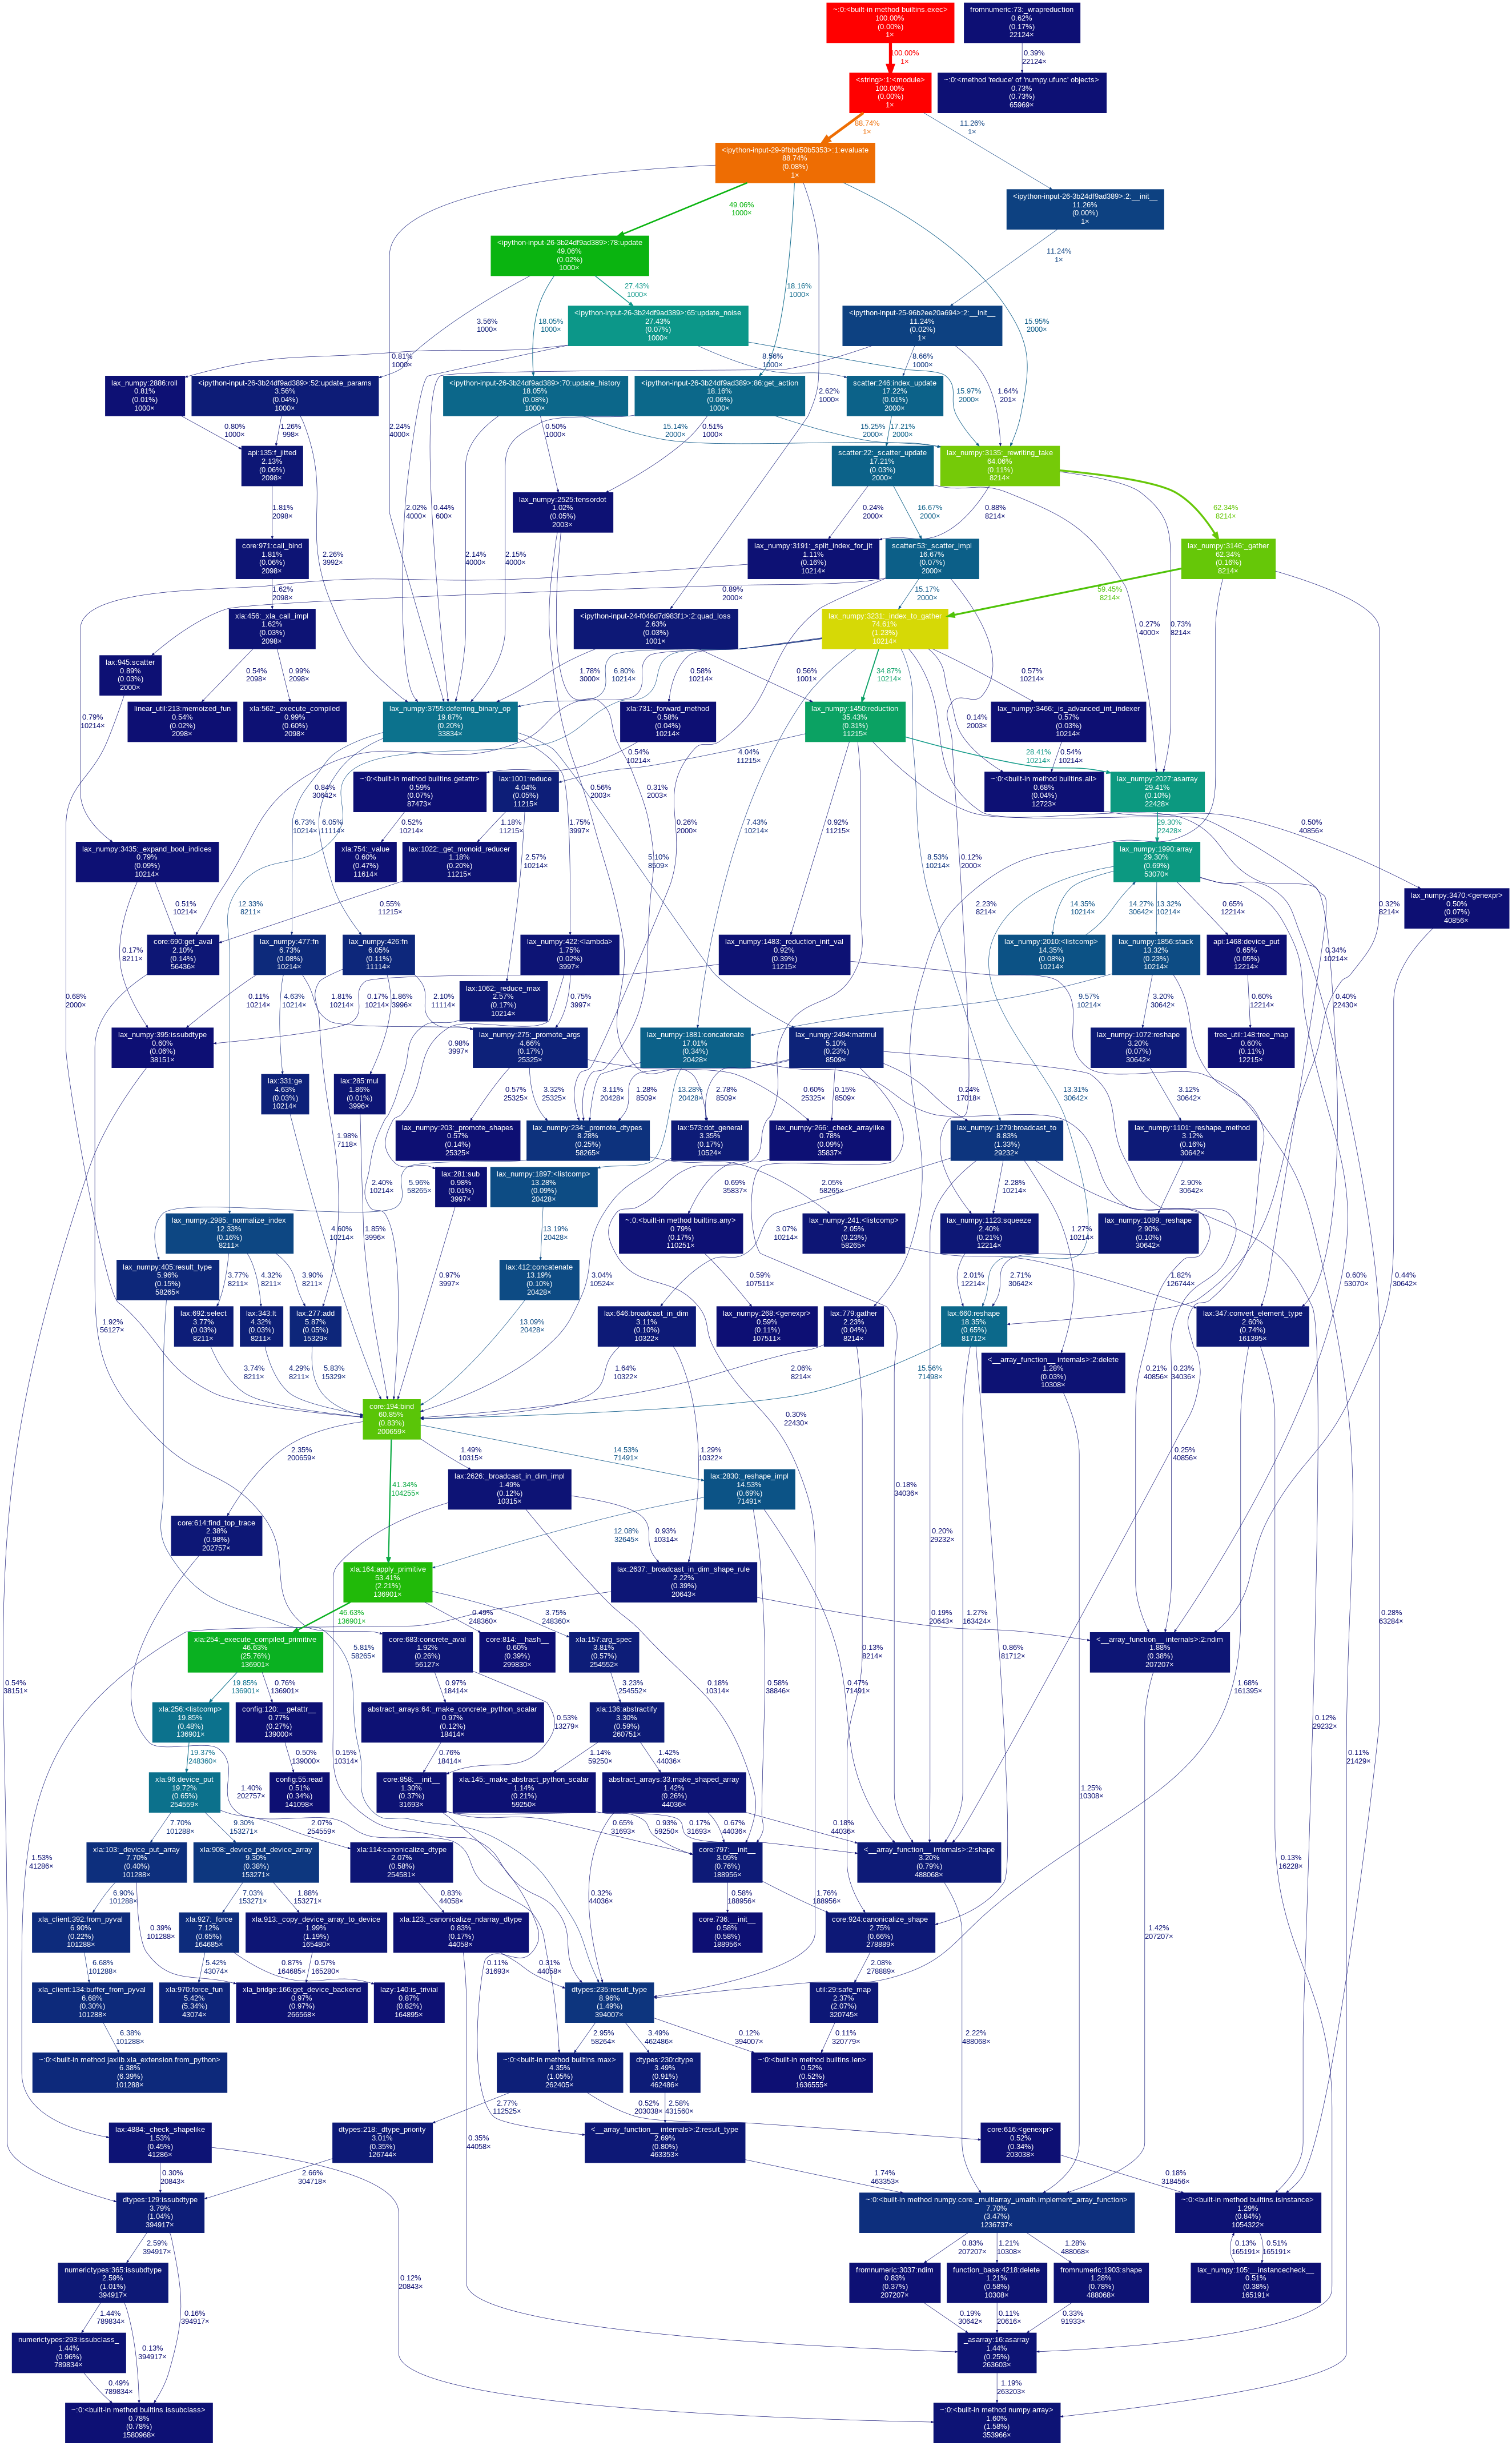

In [60]:
Image(filename="paula.png")

In [55]:
%%prun -D paula.pstats -T paula.txt

Q, R = None, None

ada_gpc_decay = True
ada_gpc_hyperparams = {'T': T, 'start_time' : 0, 'A' : A, 'B': B, 'Q': Q, 'R': R, 'lr_scale' : lr_scale, 'lr_scale_decay' : lr_scale_decay, 'H' : H, 'HH' : HH, 'decay' : ada_gpc_decay, 'include_bias' : include_bias}
evaluate(T, A, B, buzz_noise, x0, adaGPC(**{'T' : T, 'model' : GPC, 'hyperparams' : ada_gpc_hyperparams, \
                                    'eta':eta, 'eps':eps, 'sum_weight':sum_weight}), cost_fn=quad_loss)

 12%|█▏        | 121/1000 [01:05<07:52,  1.86it/s]


KeyboardInterrupt: 

In [101]:
R

In [102]:
print(R)

None


In [ ]:
class adaGPC:
    def __init__(self, T, model, hyperparams, eta = 1.00, eps = 0.00001, sum_weight = 1.0):

        # Start From Uniform Distribution
        self.T = T
        self.weights = onp.zeros(self.T)
        self.weights[0] = 1.
        self.probs = self.weights / self.T

        self.dummy_weight = 1.

        # Track current timestep
        self.t = 0 

        # Store Model Hyperparameters
        self.eta, self.eps, self.sum_weight = eta, eps, sum_weight

        self.u = np.zeros((hyperparams['B'][0].shape[1], 1))
        
        self.alive = set([0]) # Keep track of alive experts

        # Precompute time of death at initialization
        self.tod = onp.arange(T)
        for i in range(T):
          self.tod[i] = i + lifetime(i+1)
        self.tod[0] = T//10

        # Maintain Dictionary of Active Learners
        self.learners = {}
        self.learners[0] = model(**hyperparams)

        # Maintain a Dummy Controller
        self.dummy = model(**hyperparams)

        self.A, self.B = hyperparams['A'], hyperparams['B']
        self.K = LQR(T, hyperparams['A'], hyperparams['B'], hyperparams['Q'], hyperparams['R']).K

        # Store Baseline Controller Architecture for future use 
        self.model = model
        self.hyperparams = hyperparams
        
    def get_action(self, x):
      #best = onp.where(abs(self.weights - onp.max(self.weights)) < self.eps)[0][0]
      #if(best in self.alive):
      #  if(self.weights[best] > self.dummy_weight):
      #    self.u = self.learners[best].get_action(x)
      #  else:
      #    self.u = -self.K[self.t] @ x
      #else:
      u = np.zeros((self.hyperparams['B'][0].shape[1], 1))
      W = 0
      for i in self.alive:
        u += self.weights[i] * self.learners[i].get_action(x)
        W += self.weights[i]
      Wtotal = W + self.dummy_weight
      self.u = (1. / Wtotal) * u + self.dummy_weight / Wtotal * (-self.K[self.t] @ x)
      return self.u 
    
    def update(self, x):



      loss_zero = self.dummy.policy_loss(self.dummy.M, self.dummy.bias, self.dummy.w, self.t)
      self.dummy_weight *= onp.exp(-self.eta * loss_zero)
      self.dummy_weight = max(self.dummy_weight, self.eps)
      self.dummy_weight = min(self.dummy_weight, inf)

      # Update weights and (old enough) models
      for i in range(min(self.t+1, self.T-21)):
        # If not yet dead, update with its weight
        if(i in self.alive):
          loss_i = self.learners[i].policy_loss(self.learners[i].M, self.learners[i].bias, self.learners[i].w, self.t)
          self.weights[i] *= onp.exp(-self.eta * loss_i)
          self.weights[i] = max(self.weights[i], self.eps)
          self.weights[i] = min(self.weights[i], inf)
          self.learners[i].update(x, self.u)

      self.dummy.update_noise(x) 
      self.dummy.update_history(x, self.u)
      
      self.t += 1

      # One is born
      if(self.t < self.T-20 and (self.t+1)%32==0):
        self.alive.add(self.t)
        hyperparams = self.hyperparams.copy()
        hyperparams['A'] = self.A[self.t:]
        hyperparams['B'] = self.B[self.t:]
        hyperparams['start_time'] = self.t
        hyperparams['K'] = self.K[self.t:]
        self.weights[self.t] = self.dummy_weight / 2
        self.learners[self.t] = self.model(**hyperparams)
        self.learners[self.t].x, self.learners[self.t].u, self.learners[self.t].w = self.dummy.x, self.dummy.u, self.dummy.w

      # At most one dies
      kill_list = np.where(self.tod == self.t)
      if len(kill_list[0]):
        kill = int(kill_list[0][0])
        if(kill in self.alive):
          self.alive.remove(kill)
          del self.learners[kill]
          lost_weight = self.weights[kill]
          self.weights[kill] = 0

      max_w = max(self.dummy_weight, onp.max(self.weights))
      if(max_w<1):
        self.weights /= max_w
        self.dummy_weight /= max_w

        
    def __str__(self):
        return 'adaGPC'